<a href="https://colab.research.google.com/github/karenbennis/Xy/blob/Data_ETL/Copy_of_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br><br>**Connect to Database**<br><br>

In [115]:
# Install Java, Spark, and Findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.6/spark-2.4.6-bin-hadoop2.7.tgz
!tar xf spark-2.4.6-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.6-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

#Interact with SQL
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

# Start Spark Session(Creating spark application with name defined by appName()) ---IMPORTED WITH EVERY COLAB NOTEBOOK
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("database_transformation").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()


--2020-07-16 17:15:10--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar.1’

postgresql-42.2.9.j 100%[===================>] 892.61K  --.-KB/s    in 0.1s    

2020-07-16 17:15:10 (7.92 MB/s) - ‘postgresql-42.2.9.jar.1’ saved [914037/914037]



In [116]:
# gcloud login and check the DB
!gcloud auth login
!gcloud config set project 'xy-yelp'
!gcloud sql instances describe 'xy-yelp'

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&code_challenge=jReZORJvMGsigDqQzIL-7YevSp1XALUri5p_2j5Gvl8&code_challenge_method=S256&access_type=offline&response_type=code&prompt=select_account


Enter verification code: 4/1wGnztSqe5v1BdDafC5wdbZXK2oijxZh4IBgv9g-yAIDEN1YtXXYuy4

You are now logged in as [jasmeersangha@gmail.com].
Your current project is [xy-yelp].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID
Updated property [core/project].
backendType: SECOND_GEN
connectionName: xy-yelp:northamerica-northeast1:xy-yelp
datab

In [117]:
# download and initialize the psql proxy
!wget https://dl.google.com/cloudsql/cloud_sql_proxy.linux.amd64 -O cloud_sql_proxy
!chmod +x cloud_sql_proxy
# "connectionName" is from the previous block
!nohup ./cloud_sql_proxy -instances="xy-yelp:northamerica-northeast1:xy-yelp"=tcp:5432 &
!sleep 30s

--2020-07-16 17:15:50--  https://dl.google.com/cloudsql/cloud_sql_proxy.linux.amd64
Resolving dl.google.com (dl.google.com)... 74.125.129.190, 74.125.129.93, 74.125.129.136, ...
Connecting to dl.google.com (dl.google.com)|74.125.129.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14492253 (14M) [application/octet-stream]
Saving to: ‘cloud_sql_proxy’

cloud_sql_proxy     100%[===================>]  13.82M  --.-KB/s    in 0.08s   

2020-07-16 17:15:50 (169 MB/s) - ‘cloud_sql_proxy’ saved [14492253/14492253]

nohup: appending output to 'nohup.out'


In [118]:
db_password = 'kjhbyelpdb'

In [119]:
# Configure settings for RDS
mode = "append"
jdbc_url="jdbc:postgresql://127.0.0.1:5432/xy_yelp_db"
config = {"user":"postgres", 
          "password": db_password, 
          "driver":"org.postgresql.Driver"}

**Extract tables**

In [120]:
# Pull review table
review_df2 = spark.read.jdbc(url=jdbc_url, table='review',properties=config)
review_df2.show(5)

+--------------------+--------------------+-----+----+------+-----+-----------+-----------+
|           review_id|         review_text|stars|cool|useful|funny|review_date|review_type|
+--------------------+--------------------+-----+----+------+-----+-----------+-----------+
|cALYebKb5hygdKHql...|This is a very in...|    4|   0|     0|    0| 2011-01-12|     review|
|SawdMXLYD5ytRmMFv...|I LOVE Chic Nails...|    5|   0|     2|    0| 2011-01-20|     review|
|j-jMQdELr6AFkCcEH...|After the Padres ...|    5|   0|     0|    0| 2011-01-06|     review|
|SmUMyCUNrT9HEo_DX...|I have to admit t...|    4|   0|     1|    0| 2010-01-17|     review|
|oTB_mpCKcu-8wayQQ...|Best food, super ...|    5|   0|     1|    0| 2011-01-14|     review|
+--------------------+--------------------+-----+----+------+-----+-----------+-----------+
only showing top 5 rows



In [121]:
# Pull business table
business_df2 = spark.read.jdbc(url=jdbc_url, table='business',properties=config)
business_df2.show(5)

+--------------------+--------------------+
|           review_id|         business_id|
+--------------------+--------------------+
|fWKvX83p0-ka4JS3d...|9yKzy9PApeiPPOUJE...|
|IjZ33sJrzXqU-0X6U...|ZRJwVLyzEJq1VAihD...|
|IESLBzqUCLdSzSqm0...|6oRAC4uyJCsJl1X0W...|
|G-WvGaISbqqaMHlNn...|_1QQZuf4zZOyFCvXc...|
|1uJFq2r5QfJG_6ExM...|6ozycU1RpktNG2-1B...|
+--------------------+--------------------+
only showing top 5 rows



In [122]:
# Pull yelp_user table
user_df2 = spark.read.jdbc(url=jdbc_url, table='yelp_user',properties=config)
user_df2.show(5)

+--------------------+--------------------+
|           review_id|             user_id|
+--------------------+--------------------+
|GJGUHAAONtBSBj53c...|Z3c7xGRfeV-uMkSbA...|
|nQH2KAvAeOJOYKX99...|ryjqXdp68i2I9JPOp...|
|-yKcbjWSlmKC1zTMT...|5W-ruHmpkwLyI6Lla...|
|20aES_-g5Vyqfzojn...|vhxFLqRok6r-D_aQz...|
|W_d9w7yr3koSUXHco...|aBnKTxZzdhabTXfzt...|
+--------------------+--------------------+
only showing top 5 rows



In [123]:
# Join tables
spark_df = review_df2.join(business_df2, on="review_id", how="inner")
spark_df = spark_df.join(user_df2, on="review_id", how="inner")
spark_df.show(5)

+--------------------+--------------------+-----+----+------+-----+-----------+-----------+--------------------+--------------------+
|           review_id|         review_text|stars|cool|useful|funny|review_date|review_type|         business_id|             user_id|
+--------------------+--------------------+-----+----+------+-----+-----------+-----------+--------------------+--------------------+
|-7yxrdY13ay15rGB7...|I have been going...|    5|   0|     0|    0| 2010-01-16|     review|Lh9nz0KYyzE-YRbKu...|ayKW9eWwGFcrtJaHc...|
|-Be0UUGYuiDJVAM_Y...|Since Im big into...|    4|   0|     2|    2| 2011-01-25|     review|pa6K7DGByxBXxcVJ5...|_4lqpCYCqOQzbB6xQ...|
|-nQHHXi-d_yuW301_...|A pleasant place ...|    2|   0|     0|    0| 2011-01-12|     review|GIGI8bJfN6HyPzmEW...|4QORbyhfN01oKR_Gg...|
|2L30O7G8IQ6HILpR0...|part of a social ...|    5|   0|     0|    0| 2010-01-24|     review|qiwajZigq_2twTmYo...|ST8Yzlk2MqKlcaLqL...|
|4x5yLG7_yGLuN-w6f...|I love every plac...|    4|   0|     1| 

In [124]:
import pandas as pd
data_df = spark_df.select('*').toPandas()
data_df.head()

,review_id,review_text,stars,cool,useful,funny,review_date,review_type,business_id,user_id
0,-7yxrdY13ay15rGB7WibMA,I have been going to Arizona Auto Care since a...,5,0,0,0,2010-01-16,review,Lh9nz0KYyzE-YRbKuCYeUw,ayKW9eWwGFcrtJaHcwZUCw
1,-Be0UUGYuiDJVAM_YqeQuA,"Since Im big into breakfast foods, Im always o...",4,0,2,2,2011-01-25,review,pa6K7DGByxBXxcVJ59nWMw,_4lqpCYCqOQzbB6xQGGhrQ
2,-nQHHXi-d_yuW301_Y0EZQ,"A pleasant place in Kierland Center, but has g...",2,0,0,0,2011-01-12,review,GIGI8bJfN6HyPzmEW-QqjA,4QORbyhfN01oKR_GgBstfQ
3,2L30O7G8IQ6HILpR0t5RFA,"part of a social event, we only had app's here...",5,0,0,0,2010-01-24,review,qiwajZigq_2twTmYofPmDQ,ST8Yzlk2MqKlcaLqL2djBg
4,4x5yLG7_yGLuN-w6fV0eBw,I love every place on South Mountain. I've bee...,4,0,1,0,2011-01-02,review,9yKzy9PApeiPPOUJEtnvkg,Vk-hJ1i5ZagPM87Kv9FOnA


**Transformation**

In [125]:
def good(x):
    if x > 3:
        return 1
    if x < 4:
        return 0

# Create the class column splitting review into positive and negative
data_df['class']=data_df['stars'].apply(good)

In [126]:
#Create a length column that counts characters per review
data_df['length']=data_df['review_text'].apply(len)

In [127]:
#Finding mean values of numerical columns grouped by star rating
mean_vals=data_df.groupby(['stars']).mean()
mean_vals

,cool,useful,funny,class,length
stars,,,,,
1,0.576769,1.604806,1.056075,0.0,826.515354
2,0.719525,1.563107,0.875944,0.0,842.256742
3,0.788501,1.306639,0.694730,0.0,758.498289
4,0.954623,1.395916,0.670448,1.0,712.923142
5,0.944261,1.381780,0.608631,1.0,624.999101


**Upload class data**
<br>Currently inactive

In [110]:
# upload_class_df = data_df.filter(items=['review_id', 'class'])
# spark_class_df = spark.createDataFrame(upload_class_df)
# spark_class_df.show(4)

In [111]:
# # Write DataFrame to review_class table in Google Cloud
# spark_class_df.write.jdbc(url=jdbc_url, table='review_class', mode=mode, properties=config)

<br></br>**Analysis of data**<br></br>

In [128]:
data_df.nunique()

review_id      10000
review_text     9998
stars              5
cool              29
useful            28
funny             29
review_date      219
review_type        1
business_id     4174
user_id         6403
class              2
length          2134
dtype: int64


**Review_id is unique (primary key) and the text associated is almost always unique as well.**

**"type" can be dropped, as all are identified as "review"**


(array([ 749.,    0.,  927.,    0.,    0., 1461.,    0., 3526.,    0.,
        3337.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

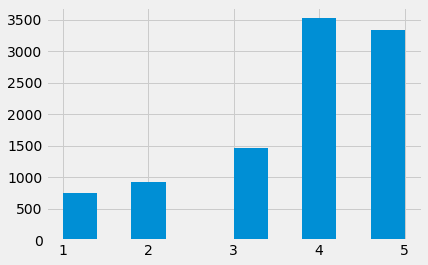

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.hist(data_df['stars'])

**There is a bias for higher ratings in this data set**

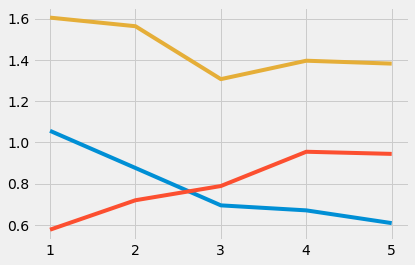

In [130]:
plt.plot(mean_vals[['funny','cool','useful']])

**'Cool' evaluations are the only of the 3 that have a positive correlation with star ratings**

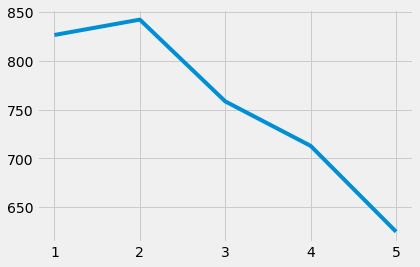

In [131]:
plt.plot(mean_vals[['length']])

**The longer reviews tend to be lower ratings.**

(array([3137.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6863.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

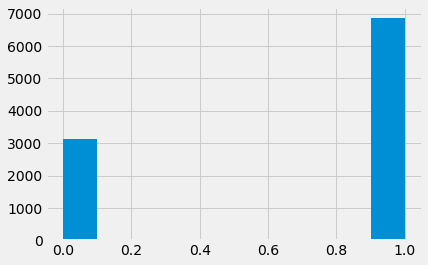

In [132]:
plt.hist(data_df['class'])

<br></br>**Pipeline**<br></br>

In [144]:
#Drop columns
nb_model_df=data_df.copy()

In [156]:
#Change from pandas to spark
df = spark.createDataFrame(nb_model_df)
df.show()

+--------------------+--------------------+-----+----+------+-----+-----------+-----------+--------------------+--------------------+-----+------+
|           review_id|         review_text|stars|cool|useful|funny|review_date|review_type|         business_id|             user_id|class|length|
+--------------------+--------------------+-----+----+------+-----+-----------+-----------+--------------------+--------------------+-----+------+
|-7yxrdY13ay15rGB7...|I have been going...|    5|   0|     0|    0| 2010-01-16|     review|Lh9nz0KYyzE-YRbKu...|ayKW9eWwGFcrtJaHc...|    1|   670|
|-Be0UUGYuiDJVAM_Y...|Since Im big into...|    4|   0|     2|    2| 2011-01-25|     review|pa6K7DGByxBXxcVJ5...|_4lqpCYCqOQzbB6xQ...|    1|  1348|
|-nQHHXi-d_yuW301_...|A pleasant place ...|    2|   0|     0|    0| 2011-01-12|     review|GIGI8bJfN6HyPzmEW...|4QORbyhfN01oKR_Gg...|    0|   813|
|2L30O7G8IQ6HILpR0...|part of a social ...|    5|   0|     0|    0| 2010-01-24|     review|qiwajZigq_2twTmYo...|ST8Yzl

In [157]:
# Import functions
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer

In [158]:
# Create all the features to the data set
pos_neg_to_num = StringIndexer(inputCol='class',outputCol='label')
tokenizer = Tokenizer(inputCol="review_text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
hashingTF = HashingTF(inputCol="stop_tokens", outputCol='hash_token')
idf = IDF(inputCol='hash_token', outputCol='idf_token')

In [159]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector
# Create feature vector 
clean_up = VectorAssembler(inputCols=['idf_token', 'length'], outputCol='features')

In [160]:
# Create and run a data processing Pipeline
from pyspark.ml import Pipeline
data_prep_pipeline = Pipeline(stages=[pos_neg_to_num, tokenizer, stopremove, hashingTF, idf, clean_up])

In [161]:
# Fit and transform the pipeline
cleaner = data_prep_pipeline.fit(df)
cleaned = cleaner.transform(df)

In [162]:
#Drop intermediate columns
x=cleaned.select('features','label')

In [163]:
# Break data down into a training set and a testing set
training, testing = x.randomSplit([0.7, 0.3], 21)

In [164]:
from pyspark.ml.classification import NaiveBayes
# Create a Naive Bayes model and fit training data
nb = NaiveBayes()
predictor = nb.fit(training)

In [165]:
# Use the Class Evaluator for a cleaner description
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

acc_eval = MulticlassClassificationEvaluator()
acc = acc_eval.evaluate(predictor.transform(testing))
print("Accuracy of model at predicting reviews was: %f" % acc)

Accuracy of model at predicting reviews was: 0.751213


In [167]:
nn_df=cleaned.select('stars','features')
nn_df.show()

+-----+--------------------+
|stars|            features|
+-----+--------------------+
|    5|(262145,[9521,133...|
|    4|(262145,[78,3188,...|
|    2|(262145,[1846,410...|
|    5|(262145,[8804,198...|
|    4|(262145,[17141,24...|
|    5|(262145,[30006,30...|
|    3|(262145,[3921,517...|
|    4|(262145,[2325,243...|
|    5|(262145,[18320,21...|
|    5|(262145,[22622,38...|
|    5|(262145,[14,329,1...|
|    5|(262145,[9988,171...|
|    1|(262145,[133,2401...|
|    5|(262145,[20719,32...|
|    4|(262145,[14,4622,...|
|    2|(262145,[9287,156...|
|    5|(262145,[82495,11...|
|    3|(262145,[13957,27...|
|    3|(262145,[2640,530...|
|    4|(262145,[14,13677...|
+-----+--------------------+
only showing top 20 rows

